In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%%bash
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 609.4 kB/s eta 0:00:00


In [3]:
import math
import pandas as pd
import tensorflow as tf
import kerastuner.tuners as kt
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

<ipython-input-3-035ebb23ec60>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner.tuners as kt


In [20]:
df=pd.read_csv('gdrive/MyDrive/AllPlayerYesSalaryCleaned.csv')

In [21]:
columns=df.columns
print(columns)
#print(columns)
sc = df[(df['Player'] == "Stephen Curry") & (df['Season'] == 2023)].index
jm = df[(df['Player'] == "Ja Morant") & (df['Season'] == 2023)].index
print(sc,jm)
gb1 = df[(df['Player'] == "Rudy Gobert") & (df['Season'] == 2023)].index
gb2 = df[(df['Player'] == "Rudy Gobert") & (df['Season'] == 2022)].index
gb3 = df[(df['Player'] == "Rudy Gobert") & (df['Season'] == 2021)].index
gb4 = df[(df['Player'] == "Rudy Gobert") & (df['Season'] == 2020)].index
print(gb1,gb2,gb3,gb4)
wanted_columns=['3P', '3P%', '2P', '2P%', 'FT%', 'ORB', 'DRB',
       'AST', 'STL', 'BLK', 'TOV', 'PTS', 'ORB%', 'DRB%', 'AST%', 'STL%',
       'BLK%', 'USG%', 'PG%', 'SG%', 'SF%', 'PF%', 'C%', 'PGA', 'Blkd',
       'Dist.', '%2PFGA', '0-3%FGA', '3-10%FGA', '10-16%FGA', '16-3P%FGA',
       '%3PFGA', '0-3FG%', '3-10FG%', '10-16FG%', '16-3PFG%', '2P%A', '3P%A',
       'Dunk%FGA', 'C3%3PA', 'C33P%', 'TruePos']
for column in wanted_columns:
    columns=columns.drop(column)

df=df.drop(columns=columns)

df=df.fillna(0)

df


Index(['Unnamed: 0', 'Player', 'Tm', 'G', '3P', '3P%', '2P', '2P%', 'FT%',
       'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'ORB%', 'DRB%', 'AST%',
       'STL%', 'BLK%', 'USG%', 'PG%', 'SG%', 'SF%', 'PF%', 'C%', 'PGA', 'Blkd',
       'Dist.', '%2PFGA', '0-3%FGA', '3-10%FGA', '10-16%FGA', '16-3P%FGA',
       '%3PFGA', '0-3FG%', '3-10FG%', '10-16FG%', '16-3PFG%', '2P%A', '3P%A',
       'Dunk%FGA', 'C3%3PA', 'C33P%', 'Season', 'Salary', 'TruePos'],
      dtype='object')
Int64Index([10797], dtype='int64') Int64Index([11024], dtype='int64')
Int64Index([10854], dtype='int64') Int64Index([10334], dtype='int64') Int64Index([9789], dtype='int64') Int64Index([9305], dtype='int64')


,3P,3P%,2P,2P%,FT%,ORB,DRB,AST,STL,BLK,...,0-3FG%,3-10FG%,10-16FG%,16-3PFG%,2P%A,3P%A,Dunk%FGA,C3%3PA,C33P%,TruePos
0,0.0,0.095,4.8,0.447,0.762,1.7,3.5,1.6,1.2,0.3,...,0.653,0.341,0.363,0.369,0.548,1.000,0.101,0.095,0.000,2.03
1,0.1,0.500,3.3,0.388,0.738,1.6,1.9,1.7,0.4,0.8,...,0.650,0.265,0.269,0.276,0.700,1.000,0.092,0.500,1.000,1.99
2,0.4,0.302,6.9,0.478,0.809,2.7,7.4,3.3,1.1,1.1,...,0.652,0.410,0.358,0.393,0.494,1.000,0.086,0.563,0.370,3.44
3,0.3,0.257,0.7,0.302,0.773,0.3,1.2,2.0,0.8,0.1,...,0.545,0.182,0.100,0.200,0.211,0.667,0.010,0.171,0.167,1.03
4,2.1,0.423,5.7,0.468,0.887,1.0,3.4,3.8,1.3,0.2,...,0.596,0.414,0.417,0.427,0.421,0.855,0.043,0.273,0.459,2.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11202,0.3,0.321,1.4,0.529,0.684,0.3,1.4,2.1,0.3,0.2,...,0.591,0.615,0.400,0.286,0.297,0.889,0.000,0.250,0.286,1.01
11203,0.1,0.176,1.9,0.622,0.692,1.3,1.8,1.4,1.0,0.1,...,0.806,0.494,0.250,0.667,0.549,1.000,0.051,0.706,0.208,4.12
11204,2.1,0.335,6.1,0.476,0.886,0.8,2.2,10.2,1.1,0.1,...,0.552,0.426,0.529,0.410,0.174,0.325,0.000,0.050,0.304,1.00
11205,0.0,0.000,2.5,0.649,0.686,1.7,2.6,0.7,0.2,0.3,...,0.722,0.533,0.750,0.000,0.838,0.000,0.153,0.500,0.000,5.00


In [16]:
sc=10797
jm=11024

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df[['3P', '3P%', '2P', '2P%', 'FT%', 'ORB', 'DRB',
       'AST', 'STL', 'BLK', 'TOV', 'PTS', 'ORB%', 'DRB%', 'AST%', 'STL%',
       'BLK%', 'USG%', 'PG%', 'SG%', 'SF%', 'PF%', 'C%', 'PGA', 'Blkd',
       'Dist.', '%2PFGA', '0-3%FGA', '3-10%FGA', '10-16%FGA', '16-3P%FGA',
       '%3PFGA', '0-3FG%', '3-10FG%', '10-16FG%', '16-3PFG%', '2P%A', '3P%A',
       'Dunk%FGA', 'C3%3PA', 'C33P%']], df['TruePos'], test_size=0.2, random_state=42)
x_train.shape

(8965, 41)

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def scale_datasets(x_train, x_test):
  """
  Standard Scale test and train data
  """
  standard_scaler = MinMaxScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)
x_train_scaled

,3P,3P%,2P,2P%,FT%,ORB,DRB,AST,STL,BLK,...,%3PFGA,0-3FG%,3-10FG%,10-16FG%,16-3PFG%,2P%A,3P%A,Dunk%FGA,C3%3PA,C33P%
0,0.094340,0.321,0.041322,0.413,0.833,0.018519,0.052632,0.051282,0.000000,0.000000,...,0.535,0.000,0.333,0.222,0.536,0.474,0.765,0.000000,0.208,0.273
1,0.188679,0.389,0.198347,0.598,0.780,0.185185,0.219298,0.196581,0.172414,0.068182,...,0.378,0.769,0.400,0.375,0.476,0.554,0.883,0.166407,0.495,0.337
2,0.000000,0.000,0.256198,0.548,0.606,0.296296,0.280702,0.111111,0.275862,0.454545,...,0.000,0.645,0.522,0.429,0.556,0.717,0.000,0.093313,0.000,0.000
3,0.018868,0.240,0.677686,0.487,0.850,0.444444,0.570175,0.196581,0.275862,0.295455,...,0.019,0.582,0.432,0.422,0.468,0.567,1.000,0.069984,0.120,0.333
4,0.056604,0.217,0.049587,0.507,0.286,0.092593,0.096491,0.051282,0.137931,0.068182,...,0.532,0.846,0.333,0.000,0.478,0.811,1.000,0.000000,0.530,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8960,0.056604,0.296,0.099174,0.617,0.333,0.055556,0.043860,0.025641,0.103448,0.022727,...,0.365,0.656,0.500,0.500,0.556,0.517,0.750,0.273717,0.296,0.250
8961,0.169811,0.405,0.074380,0.462,0.882,0.166667,0.175439,0.094017,0.206897,0.136364,...,0.544,0.634,0.355,0.143,0.310,0.522,0.957,0.063764,0.277,0.458
8962,0.000000,0.143,0.578512,0.453,0.702,0.759259,0.596491,0.136752,0.517241,0.272727,...,0.014,0.583,0.316,0.352,0.411,0.466,1.000,0.124417,0.286,0.250
8963,0.000000,0.000,0.115702,0.407,0.586,0.203704,0.184211,0.042735,0.103448,0.113636,...,0.006,0.608,0.195,0.359,0.217,0.611,0.000,0.192846,0.000,0.000


In [ ]:
encoder_input=keras.Input(shape=(41),dtype='float32')
encoder_out=keras.layers.Dense(2,activation='linear')(encoder_input)
encoder=keras.Model(encoder_input,encoder_out,name='encoder')
decoder_output=keras.layers.Dense(41,activation='linear')(encoder_out)


opt=keras.optimizers.Adam(learning_rate=.001)
autoencoder=keras.Model(encoder_input,decoder_output,name='autoencoder')
autoencoder.summary()



Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 41)]              0         
                                                                 
 dense (Dense)               (None, 2)                 84        
                                                                 
 dense_1 (Dense)             (None, 41)                123       
                                                                 
Total params: 207 (828.00 Byte)
Trainable params: 207 (828.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
autoencoder.compile(opt,loss='mse')

In [ ]:
autoencoder.fit(x_train_scaled,x_train_scaled,epochs=40,batch_size=32,validation_split=.1)

Epoch 1/40
253/253 [==============================] - 2s 4ms/step - loss: 0.0822 - val_loss: 0.0370
Epoch 2/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0347
Epoch 3/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0306
Epoch 4/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0263
Epoch 5/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0244
Epoch 6/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 7/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0233
Epoch 8/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0230
Epoch 9/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0227
Epoch 10/40
253/253 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0225

In [ ]:
example=encoder.predict([x_test_scaled])
print(example)
#some error annlysis

X=df[['3P', '3P%', '2P', '2P%', 'FT%', 'ORB', 'DRB',
       'AST', 'STL', 'BLK', 'TOV', 'PTS', 'ORB%', 'DRB%', 'AST%', 'STL%',
       'BLK%', 'USG%', 'PG%', 'SG%', 'SF%', 'PF%', 'C%', 'PGA', 'Blkd',
       'Dist.', '%2PFGA', '0-3%FGA', '3-10%FGA', '10-16%FGA', '16-3P%FGA',
       '%3PFGA', '0-3FG%', '3-10FG%', '10-16FG%', '16-3PFG%', '2P%A', '3P%A',
       'Dunk%FGA', 'C3%3PA', 'C33P%']]
standard_scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    standard_scaler.fit_transform(X),
    columns = X.columns)

results_player=encoder.predict(X_scaled)
print(len(results_player))

71/71 [==============================] - 0s 2ms/step
[[ 1.1558056   0.16596913]
 [ 1.2462249  -1.2304186 ]
 [ 0.28709242 -1.0530083 ]
 ...
 [ 1.3394601  -1.2382213 ]
 [ 1.1671754  -1.6057943 ]
 [ 1.2754234  -1.1101152 ]]
351/351 [==============================] - 1s 2ms/step
11207


In [6]:
import numpy as np
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]
def get_color_gradient(n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    '#FF0000'
    '#FFFF00'
    """
    c1_rgb = np.array(hex_to_RGB('#FF0000'))/255
    c2_rgb = np.array(hex_to_RGB('#FFFF00'))/255
    rgb_color = ((1-n)*c1_rgb + (n*c2_rgb))
    return "#" + "".join([format(int(round(val*255)), "02x") for val in rgb_color])


In [9]:
#min max scale by position here then multiply by color value

standard_scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    standard_scaler.fit_transform(df),
    columns = df.columns)
position=df_scaled['TruePos']
position[0]

0.25495049504950495

In [10]:
df_encoded=pd.read_csv('gdrive/MyDrive/AllPlayerYesSalaryEncoded.csv')
df_encoded
new_encoded_df=pd.DataFrame()
new_encoded_df['x']=df_encoded['feature1']
new_encoded_df['y']=df_encoded['feature2']

In [22]:
gb1=10854
gb2=10334
gb3=9789
gb4=9305

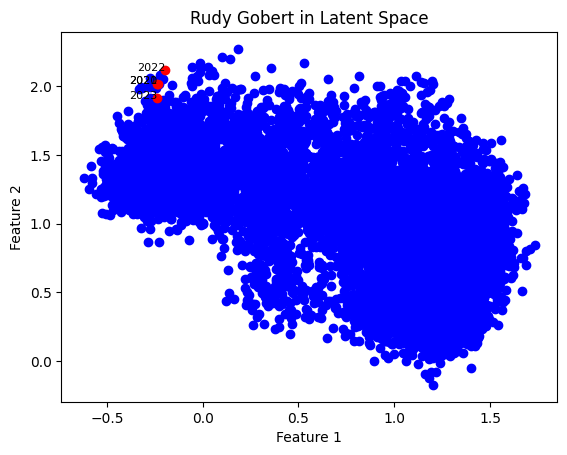

In [24]:
x_scatter_list=new_encoded_df['x'].tolist()
y_scatter_list=new_encoded_df['y'].tolist()

for i in range(len(x_scatter_list)):
  if i==gb1:
    plt.text(x_scatter_list[i], y_scatter_list[i], '2023', fontsize=8, ha='right')
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],c='r')
  elif i ==gb2:
    plt.text(x_scatter_list[i], y_scatter_list[i], '2022', fontsize=8, ha='right')
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],c='r')
  elif i ==gb3:
    plt.text(x_scatter_list[i], y_scatter_list[i], '2021', fontsize=8, ha='right')
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],c='r')
  elif i ==gb4:
    plt.text(x_scatter_list[i], y_scatter_list[i], '2020', fontsize=8, ha='right')
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],c='r')
  else:
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],c='b')
plt.title("Rudy Gobert in Latent Space")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

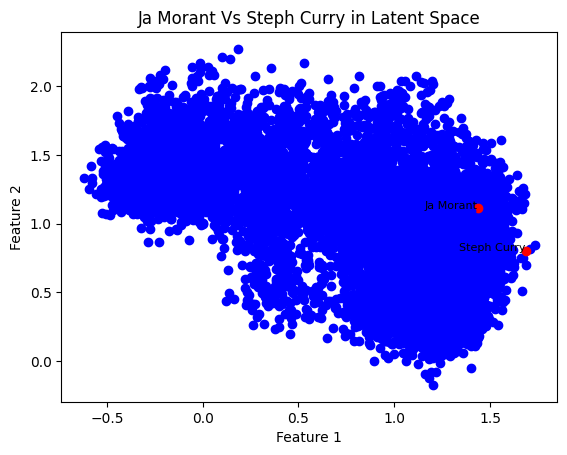

In [17]:
x_scatter_list=new_encoded_df['x'].tolist()
y_scatter_list=new_encoded_df['y'].tolist()

for i in range(len(x_scatter_list)):
  if i==jm:
    plt.text(x_scatter_list[i], y_scatter_list[i], 'Ja Morant', fontsize=8, ha='right')
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],c='r')
  elif i ==sc:
    plt.text(x_scatter_list[i], y_scatter_list[i], 'Steph Curry', fontsize=8, ha='right')
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],c='r')
  else:
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],c='b')
plt.title("Ja Morant Vs Steph Curry in Latent Space")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

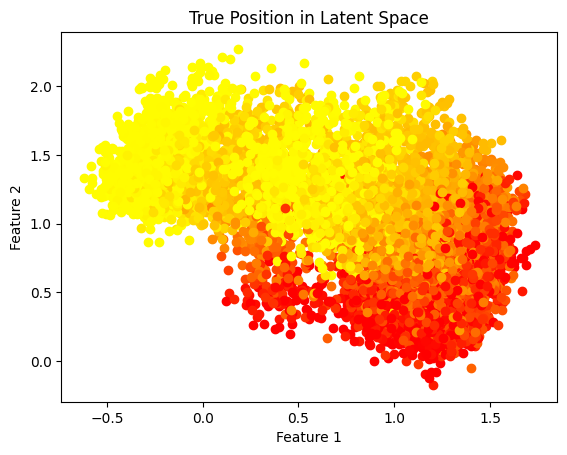

<Figure size 640x480 with 0 Axes>

In [11]:
x_scatter_list=new_encoded_df['x'].tolist()
y_scatter_list=new_encoded_df['y'].tolist()

for i in range(len(x_scatter_list)):
  if True: #i%100==0:
    color=get_color_gradient(position[i])
    plt.scatter(x=x_scatter_list[i],y=y_scatter_list[i],color=color)
    #plt.scatter(x=x_scatter,y=y_scatter,color='b')
plt.title("True Position in Latent Space")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
plt.savefig("TruePos.png")

In [ ]:
kmeans=KMeans(n_clusters=10)
label=kmeans.fit_predict(new_encoded_df)
label=label.flatten()
label

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([8, 5, 3, ..., 0, 1, 9], dtype=int32)

#fffc00
{0: {'x': [1.5239366, 1.2926054, 1.3311672, 1.2777394, 1.2525905, 1.4665498, 1.3897463, 1.2549384, 1.4286208, 1.5520086, 1.2528559, 1.2373346, 1.3050954, 1.4948285, 1.3291345, 1.5538545, 1.4192489, 1.1700637, 1.560986, 1.4909959, 1.2221851, 1.2530928, 1.31234, 1.5509771, 1.3038814, 1.320121, 1.2917967, 1.2064825, 1.209783, 1.1407712, 1.5311172, 1.4756473, 1.3978704, 1.3424941, 1.3131912, 1.4176983, 1.4393935, 1.4845201, 1.3314879, 1.1642749, 1.4357041, 1.4865717, 1.3166686, 1.2388073, 1.1316752, 1.3335645, 1.2950135, 1.5961875, 1.4216789, 1.5061072, 1.4929246, 1.4576608, 1.3916042, 1.4671698, 1.3139902, 1.3791877, 1.2614187, 1.58535, 1.3035458, 1.4642389, 1.4668956, 1.1292135, 1.4757476, 1.3083801, 1.3412793, 1.5460823, 1.4482856, 1.4477978, 1.1157824, 1.3451729, 1.222052, 1.2261134, 1.3338947, 1.2815062, 1.5328423, 1.5609789, 1.3238102, 1.2193484, 1.2924658, 1.2158375, 1.1708945, 1.5103103, 1.360815, 1.6154755, 1.4334432, 1.2463937, 1.4871234, 1.185947, 1.2640514, 1.1426686, 1

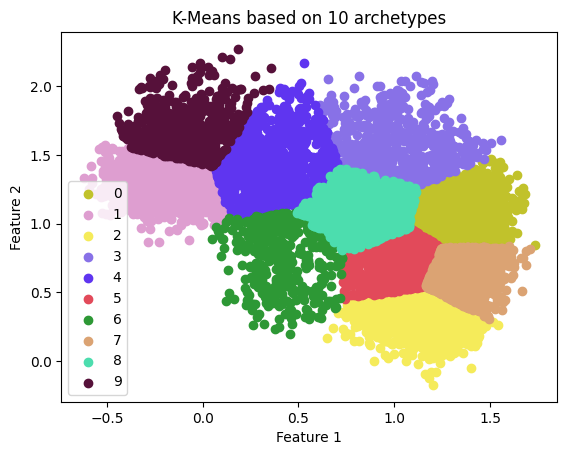

In [ ]:
print(color)
color_ten=['#C1C22B', '#DE9ED0', '#F5EB5A', '#8871E7', '#5F35F0', '#E24A5A', '#2D9835', '#DBA373', '#4CDDAE', '#56113A']
#group into 10 groups based on labels and then plot it all at once
#label is the classifications
#
color_dict={}
for i in range(10):
  color_dict[i]={'x':[],'y':[]}
for i in range(len(x_scatter_list)):
  color_dict[label[i]]['x'].append(x_scatter_list[i])
  color_dict[label[i]]['y'].append(y_scatter_list[i])
print(color_dict)
for i in range(10):
  x=color_dict[i]['x']
  y=color_dict[i]['y']
  plt.scatter(x=color_dict[i]['x'],y=color_dict[i]['y'],color=color_ten[i], label=i)
plt.title("K-Means based on 10 archetypes")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()



In [33]:
gmm=GaussianMixture(n_components=10)
gmm.fit(new_encoded_df)
labels_gmm=gmm.predict(new_encoded_df)
labels_gmm=labels_gmm.flatten()
labels_gmm
df=pd.read_csv('gdrive/MyDrive/AllPlayerYesSalaryCleaned.csv')
df['label']=labels_gmm
df.to_csv('gdrive/MyDrive/DataWithGMMLabel.csv')

#fffc00
{0: {'x': [1.0730509, 1.2586628, 1.081228, 1.22848, 1.0273651, 1.2029935, 1.1881393, 1.211332, 1.1178638, 1.202459, 1.0811352, 1.3295275, 1.2406259, 1.09542, 1.0459486, 1.3569648, 1.1830003, 1.2469358, 1.2059853, 1.1272582, 1.2652196, 1.1788771, 1.2992729, 0.9501302, 0.97727084, 1.1312127, 1.3301557, 1.1528856, 1.2269514, 1.0521176, 1.0637021, 1.1178344, 1.2681745, 1.4065857, 1.1566812, 1.2886183, 1.3018517, 1.3423932, 1.156286, 1.1438631, 1.230365, 1.2384608, 0.9517503, 1.0959597, 1.3672031, 1.2460055, 1.2135767, 1.1796675, 1.0474824, 1.1471702, 1.0592365, 1.1538521, 1.3475931, 1.1825434, 1.1236035, 1.2547779, 1.1911492, 1.2503839, 1.2413884, 1.2379801, 1.0678663, 1.2302011, 1.2876233, 1.201219, 1.3409729, 1.1765617, 1.1316832, 1.2563308, 1.0591888, 1.2204322, 1.3159517, 1.0796158, 1.1433487, 1.1034988, 1.1471251, 1.3497814, 1.2138567, 1.2316629, 1.1748047, 1.264862, 1.0560099, 1.317142, 1.2334683, 1.1557041, 1.0867617, 1.1205845, 1.1340674, 1.1320426, 1.287993, 1.2908877, 1.1

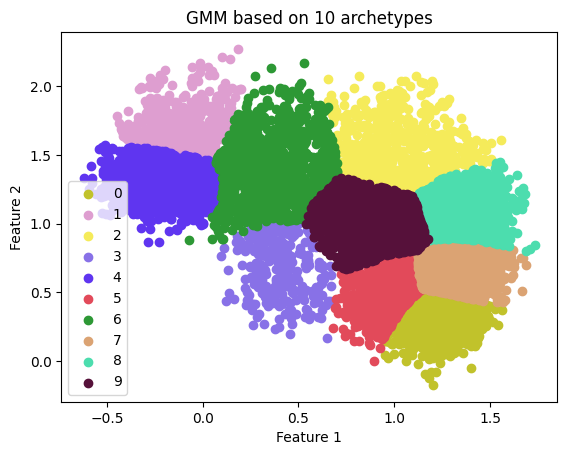

In [35]:
print(color)
color_ten=['#C1C22B', '#DE9ED0', '#F5EB5A', '#8871E7', '#5F35F0', '#E24A5A', '#2D9835', '#DBA373', '#4CDDAE', '#56113A']
#group into 10 groups based on labels and then plot it all at once
#label is the classifications
#
color_dict={}
for i in range(10):
  color_dict[i]={'x':[],'y':[]}
for i in range(len(x_scatter_list)):
  color_dict[labels_gmm[i]]['x'].append(x_scatter_list[i])
  color_dict[labels_gmm[i]]['y'].append(y_scatter_list[i])
print(color_dict)
for i in range(10):
  x=color_dict[i]['x']
  y=color_dict[i]['y']
  plt.scatter(x=color_dict[i]['x'],y=color_dict[i]['y'],color=color_ten[i], label=i)
plt.title("GMM based on 10 archetypes")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

Int64Index([ 4177,  4633,  5111,  6016,  6488,  6968,  7448,  7919,  8406,
             8922,  9422,  9920, 10461, 10979],
           dtype='int64')


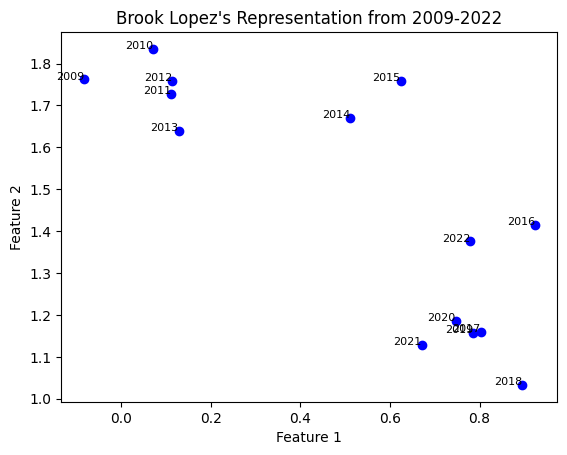

In [ ]:
#add the graphs from the presentation here
#graph 1) JaMorant and Steph Curry
#graph 2) Rudy Gobert
brook = X_scaled[(df['Player'] == "Brook Lopez")].index
print(brook)
starting_year=2009
for i in range(len(brook)):
  x=x_scatter_list[brook[i]]
  y=y_scatter_list[brook[i]]
  plt.scatter(x, y,c='b')
  temp_year=starting_year+i
  temp_year=str(temp_year)
  plt.text(x, y, temp_year, fontsize=8, ha='right')
plt.title("Brook Lopez's Representation from 2009-2022")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
#plot teams over the years

In [ ]:
#encoded_dict={'feature1':x_scatter_list,'feature2':y_scatter_list}
new_df=pd.DataFrame(encoded_dict)
new_df

,feature1,feature2
0,1.015397,0.993911
1,1.163896,0.780739
2,1.376643,1.651960
3,0.935650,0.287197
4,1.523937,0.920687
...,...,...
11202,1.007664,0.409226
11203,0.819124,1.103702
11204,1.458105,0.904180
11205,-0.245612,1.437768


In [ ]:
df=pd.read_csv('gdrive/MyDrive/AllPlayerYesSalaryCleaned.csv')
combined_df=pd.merge(df,new_df,left_index=True,right_index=True)
combined_df

,Unnamed: 0,Player,Tm,G,3P,3P%,2P,2P%,FT%,ORB,...,2P%A,3P%A,Dunk%FGA,C3%3PA,C33P%,Season,Salary,TruePos,feature1,feature2
0,0,Tariq Abdul-Wahad,ORL,46.0,0.0,0.095,4.8,0.447,0.762,1.7,...,0.548,1.000,0.101,0.095,0.000,2000.0,1594920.0,2.03,1.015397,0.993911
1,1,Tariq Abdul-Wahad,DEN,15.0,0.1,0.500,3.3,0.388,0.738,1.6,...,0.700,1.000,0.092,0.500,1.000,2000.0,1594920.0,1.99,1.163896,0.780739
2,2,Shareef Abdur-Rahim,VAN,82.0,0.4,0.302,6.9,0.478,0.809,2.7,...,0.494,1.000,0.086,0.563,0.370,2000.0,9000000.0,3.44,1.376643,1.651960
3,3,Cory Alexander,DEN,29.0,0.3,0.257,0.7,0.302,0.773,0.3,...,0.211,0.667,0.010,0.171,0.167,2000.0,1980000.0,1.03,0.935650,0.287197
4,4,Ray Allen*,MIL,82.0,2.1,0.423,5.7,0.468,0.887,1.0,...,0.421,0.855,0.043,0.273,0.459,2000.0,NaN,2.02,1.523937,0.920687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11202,11202,McKinley Wright IV,DAL,27.0,0.3,0.321,1.4,0.529,0.684,0.3,...,0.297,0.889,0.000,0.250,0.286,2023.0,NaN,1.01,1.007664,0.409226
11203,11203,Thaddeus Young,TOR,54.0,0.1,0.176,1.9,0.622,0.692,1.3,...,0.549,1.000,0.051,0.706,0.208,2023.0,8000000.0,4.12,0.819124,1.103702
11204,11204,Trae Young,ATL,73.0,2.1,0.335,6.1,0.476,0.886,0.8,...,0.174,0.325,0.000,0.050,0.304,2023.0,37096500.0,1.00,1.458105,0.904180
11205,11205,Cody Zeller,MIA,15.0,0.0,0.000,2.5,0.649,0.686,1.7,...,0.838,NaN,0.153,0.500,0.000,2023.0,743922.0,5.00,-0.245612,1.437768


In [ ]:
combined_df.to_csv('gdrive/MyDrive/AllPlayerYesSalaryEncoded.csv')

In [ ]:
df=pd.read_csv('gdrive/MyDrive/TeamNotEncodedData.csv')


In [ ]:

df=df.drop(columns=['Unnamed: 0','NRtg'])
df

,player1Feature1,player1Feature2,player2Feature1,player2Feature2,player3Feature1,player3Feature2,player4Feature1,player4Feature2,player5Feature1,player5Feature2,player6Feature1,player6Feature2,player7Feature1,player7Feature2,player8Feature1,player8Feature2
0,1.793262,0.462374,1.425073,0.117529,1.340585,-0.595223,1.193328,-0.323736,1.399907,-1.082706,0.872047,-1.029202,1.125109,-0.612078,1.619986,-1.035222
1,2.035402,0.116011,1.217779,-0.978066,1.029012,-0.845330,2.075747,-0.263675,1.230536,-0.611300,1.962617,-1.128473,2.012217,-1.197642,0.929818,-0.790122
2,1.624038,0.198613,2.662494,-0.389367,1.582267,0.557196,2.159223,-1.233361,1.267492,-0.486682,1.565536,-0.902510,1.586397,-1.099570,0.801173,-0.807810
3,1.665634,-0.307017,1.661685,-0.130368,1.930034,-0.337966,0.982349,-1.290543,2.003255,0.585468,1.361234,-0.576006,1.531711,-1.188774,1.014680,-0.877785
4,1.144830,-0.852213,1.749598,-0.315063,1.096461,-1.082687,2.729928,-0.400123,1.126550,-1.063455,1.753406,-0.587251,0.738680,-1.146615,2.003336,-1.100547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,1.416882,-0.952905,1.364945,-0.655821,1.982237,-0.747579,1.157179,-0.982961,1.502874,-0.983225,1.770005,0.376578,1.613921,0.149142,2.361587,0.065049
663,2.245130,0.542822,1.568489,-0.255307,1.926919,-0.309053,1.491518,-0.611187,1.624929,-0.783768,1.594455,-1.057754,1.250908,-0.464399,1.614732,-1.005799
664,1.556841,-0.187960,1.887353,-0.593936,1.587634,-0.863641,1.138122,-0.846780,1.721529,-1.129734,1.716349,0.570811,1.729570,0.108624,1.218256,-1.101450
665,1.225271,-1.000219,2.397093,0.197015,1.646628,-0.034823,1.255791,-1.019783,1.874744,-0.768303,1.582896,-0.895599,1.191200,-1.046972,1.343862,-0.163687


In [ ]:
standard_scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    standard_scaler.fit_transform(df),
    columns=df.columns
  )
x_train, x_test= train_test_split(df_scaled, test_size=0.2, random_state=42)
x_train.shape
x_test.shape


(134, 16)

In [ ]:
encoder_input=keras.Input(shape=(16),dtype='float32')
encoder_out=keras.layers.Dense(2,activation='linear')(encoder_input)
encoder=keras.Model(encoder_input,encoder_out,name='encoder')
decoder_output=keras.layers.Dense(16,activation='linear')(encoder_out)

opt=keras.optimizers.Adam(learning_rate=.001)
autoencoder=keras.Model(encoder_input,decoder_output,name='autoencoder')
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
 dense_3 (Dense)             (None, 16)                48        
                                                                 
Total params: 82 (328.00 Byte)
Trainable params: 82 (328.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
autoencoder.compile(opt,loss='mse')
autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_split=.1)

Epoch 1/40
15/15 [==============================] - 1s 15ms/step - loss: 0.3965 - val_loss: 0.3641
Epoch 2/40
15/15 [==============================] - 0s 4ms/step - loss: 0.3269 - val_loss: 0.3016
Epoch 3/40
15/15 [==============================] - 0s 3ms/step - loss: 0.2733 - val_loss: 0.2539
Epoch 4/40
15/15 [==============================] - 0s 5ms/step - loss: 0.2325 - val_loss: 0.2185
Epoch 5/40
15/15 [==============================] - 0s 4ms/step - loss: 0.2026 - val_loss: 0.1916
Epoch 6/40
15/15 [==============================] - 0s 3ms/step - loss: 0.1798 - val_loss: 0.1711
Epoch 7/40
15/15 [==============================] - 0s 5ms/step - loss: 0.1624 - val_loss: 0.1552
Epoch 8/40
15/15 [==============================] - 0s 5ms/step - loss: 0.1487 - val_loss: 0.1424
Epoch 9/40
15/15 [==============================] - 0s 4ms/step - loss: 0.1375 - val_loss: 0.1321
Epoch 10/40
15/15 [==============================] - 0s 4ms/step - loss: 0.1283 - val_loss: 0.1234
Epoch 11/40
15/15 

In [ ]:
results=encoder.predict(df)
print(len(results))

21/21 [==============================] - 0s 1ms/step
667


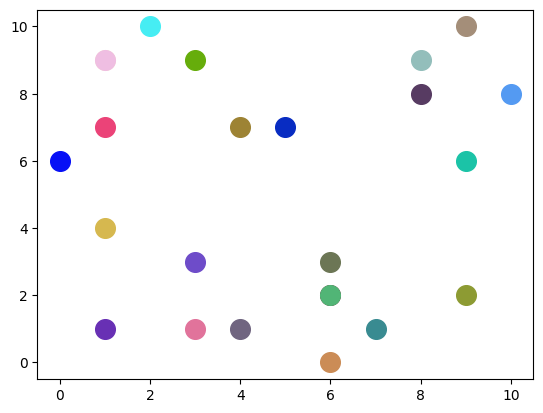

In [ ]:
#generate 23 colors and put them in a list
import random
hexadecimal_alphabets = '0123456789ABCDEF'

color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(24)]

for i in range(24):
   plt.scatter(random.randint(0, 10), random.randint(0, 10), c=color[i], s=200)

plt.show()

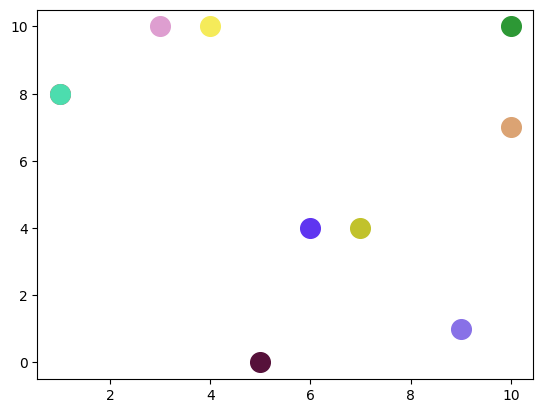

In [ ]:
import random
hexadecimal_alphabets = '0123456789ABCDEF'

color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(10)]

for i in range(10):
   plt.scatter(random.randint(0, 10), random.randint(0, 10), c=color[i], s=200)

plt.show()

In [ ]:
print(color)
colors=['#6A2132', '#93BEBB', '#398B91', '#CB8C56', '#1BC3A7', '#46EDF3', '#A48E79', '#F8E7CF', '#EB4378', '#082CC2', '#9D8334', '#549AF2', '#6E4CC9', '#6830B4', '#E1739B', '#573B62', '#0710F6', '#8D9B33', '#D6B84F', '#EFBEE2', '#66AD0B', '#6C7655', '#706580', '#51B576']
ranges=[[642,667],[617,642],[591,617],[565,591],[539,565],[513,539],[487,513],[461,487],[435,461],[408,435],[381,408],[354,381],[327,354],[299,327],[270,299],[240,270],[210,240],[180,210],[150,180],[120,150],[90,120],[60,90],[30,60],[0,30]]
print(len(ranges),len(colors))

['#6A2132', '#93BEBB', '#398B91', '#CB8C56', '#1BC3A7', '#46EDF3', '#A48E79', '#F8E7CF', '#EB4378', '#082CC2', '#9D8334', '#549AF2', '#6E4CC9', '#6830B4', '#E1739B', '#573B62', '#0710F6', '#8D9B33', '#D6B84F', '#EFBEE2', '#66AD0B', '#6C7655', '#706580', '#51B576']
24 24


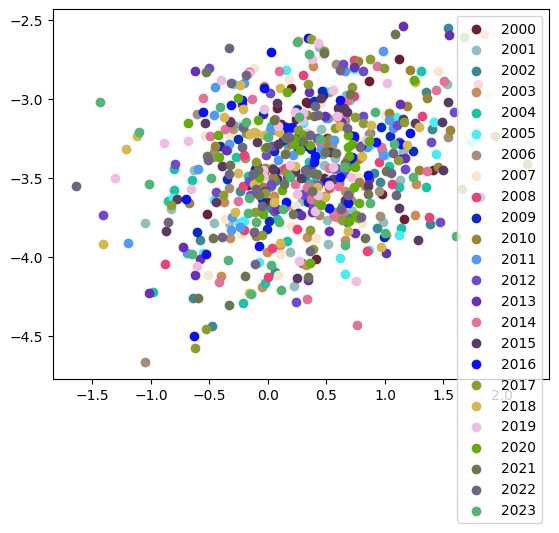

In [ ]:
x_scatter_list=[]
y_scatter_list=[]
year_range_dict={
'2000': [642,666],'2001': [617,641],'2002': [591,616],'2003': [565,590],'2004': [539,564],'2005': [513,538],'2006': [487,512],'2007': [461,486],'2008': [435,460],'2009': [408,434],'2010': [381,407],'2011': [354,380],'2012': [327,353],'2013': [299,326],'2014': [270,298],'2015': [240,269],'2016':[210,239],'2017': [180,209],'2018': [150,179],'2019': [120,149],'2020': [90,119],'2021': [60,89],'2022': [30,59],'2023': [0,29]}
output_dict={}
for i in range(24):
  year=2000+i
  output_dict[year]={'x':[],'y':[]}
for i in range(len(results)):
  x_scatter=results[i][0]
  y_scatter=results[i][1]
  #if i in [6,33,63,92,122]:
  for j in range(len(ranges)):
    if i in range(ranges[j][0],ranges[j][1]):
      year=j+2000
      output_dict[year]['x'].append(x_scatter)
      output_dict[year]['y'].append(y_scatter)

      #plt.scatter(x=x_scatter,y=y_scatter,color=colors[j], label=year)
    #plt.scatter(x=x_scatter,y=y_scatter,color='r')
  #if i%20==0:
  #color=get_color_gradient(position[i])
  #plt.scatter(x=x_scatter,y=y_scatter,color=color)
    #plt.scatter(x=x_scatter,y=y_scatter,color='b')
for i in range(24):
  year=2000+i
  plt.scatter(x=output_dict[year]['x'],y=output_dict[year]['y'],color=colors[i], label=year)
plt.legend()
plt.show()

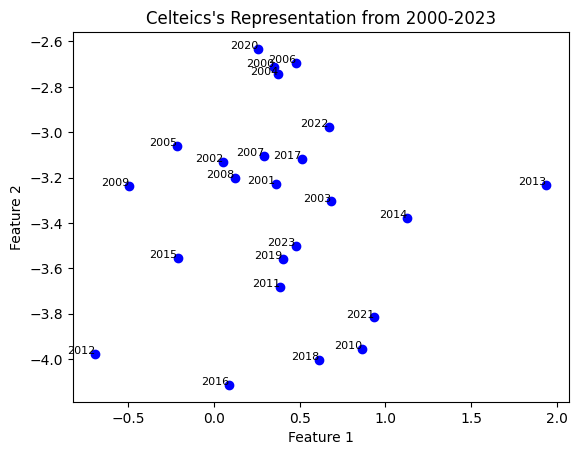

In [ ]:
bos_index=[0,30,72,94,127,156,187,217,258,294,515,338,359,391,409,435,482,505,525,555,580,597,636,659]
starting_year=2000
for i in range(len(bos_index)):
  x=results[bos_index[i]][0]
  y=results[bos_index[i]][1]
  plt.scatter(x, y,c='b')
  temp_year=starting_year+i
  temp_year=str(temp_year)
  plt.text(x, y, temp_year, fontsize=8, ha='right')
plt.title("Celtics's Representation from 2000-2023")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:

def get_color_gradient(n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    '#FF0000'
    '#FFFF00'
    """
    c1_rgb = np.array(hex_to_RGB('#FF0000'))/255
    c2_rgb = np.array(hex_to_RGB('#FFFF00'))/255
    rgb_color = ((1-n)*c1_rgb + (n*c2_rgb))
    return "#" + "".join([format(int(round(val*255)), "02x") for val in rgb_color])


In [ ]:
color_list=[]
iterable=1/25
#I have to min max the values that I put into this
for i in range(25):
  n=iterable*(i+1)
  c1_rgb = np.array(hex_to_RGB('#FF0000'))/255
  c2_rgb = np.array(hex_to_RGB('#FFFF00'))/255
  rgb_color = ((1-n)*c1_rgb + (n*c2_rgb))
  color_list.append("#" + "".join([format(int(round(val*255)), "02x") for val in rgb_color]))
print(color_list)

['#ff0a00', '#ff1400', '#ff1f00', '#ff2900', '#ff3300', '#ff3d00', '#ff4700', '#ff5200', '#ff5c00', '#ff6600', '#ff7000', '#ff7a00', '#ff8500', '#ff8f00', '#ff9900', '#ffa300', '#ffad00', '#ffb800', '#ffc200', '#ffcc00', '#ffd600', '#ffe000', '#ffeb00', '#fff500', '#ffff00']


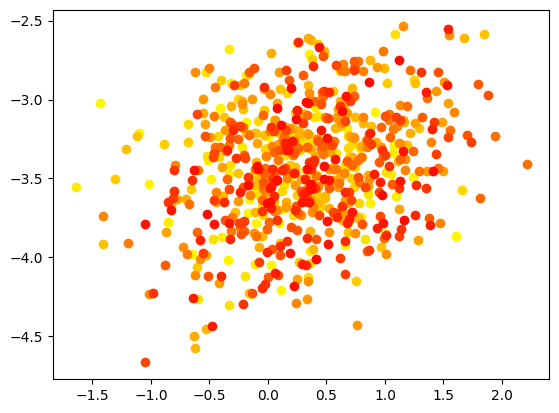

In [ ]:
x_scatter_list=[]
y_scatter_list=[]
for i in range(len(results)):
  x_scatter=results[i][0]
  y_scatter=results[i][1]
  x_scatter_list.append(x_scatter)
  y_scatter_list.append(y_scatter)
  for j in range(len(ranges)):
    if i in range(ranges[j][0],ranges[j][1]):
      year=j+2000
      output_dict[year]['x'].append(x_scatter)
      output_dict[year]['y'].append(y_scatter)
      plt.scatter(x=x_scatter,y=y_scatter,c=color_list[j])
plt.show()

In [27]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [29]:
kmeans=KMeans(n_clusters=10)
label=kmeans.fit_predict(new_encoded_df)
label=label.flatten()
label

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([3, 1, 5, ..., 6, 4, 0], dtype=int32)

['#C1C22B', '#DE9ED0', '#F5EB5A', '#8871E7', '#5F35F0', '#E24A5A', '#2D9835', '#DBA373', '#4CDDAE', '#56113A']
{0: {'x': [-0.169925, 0.12584344, -0.10246869, 0.09450046, -0.15901652, -0.49031332, -0.12913415, -0.10279729, -0.12051215, -0.3326723, -0.051999174, -0.32115486, -0.07555886, 0.13904402, -0.0818918, 0.11573688, -0.044454418, -0.07668849, -0.04112687, -0.0465137, -0.28033483, -0.2523845, 0.05261878, -0.120281, -0.10551428, -0.07535299, -0.053647004, -0.026077472, -0.38552722, -0.11079856, 0.15500227, -0.44013736, 0.042588867, 0.15667611, -0.11700853, -0.2553242, 0.07927839, -0.024923526, 0.023943044, -0.44285965, -0.1520251, 0.05049769, -0.16430324, -0.24315986, -0.31779882, -0.3090261, -0.028424881, -0.09920045, -0.042202316, 0.043121405, -0.053290866, 0.06420434, -0.11244162, -0.011042021, -0.3515623, 0.008687593, -0.21114191, -0.20104733, -0.030587368, -0.038885556, -0.23122445, -0.36560473, -0.3367909, -0.19550624, -0.24944997, -0.46327087, -0.21519229, -0.20484015, 0.0328

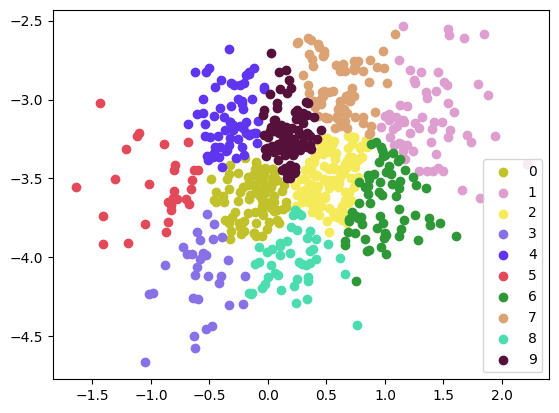

In [ ]:
print(color)
color_ten=['#C1C22B', '#DE9ED0', '#F5EB5A', '#8871E7', '#5F35F0', '#E24A5A', '#2D9835', '#DBA373', '#4CDDAE', '#56113A']
#group into 10 groups based on labels and then plot it all at once
#label is the classifications
#
color_dict={}
for i in range(10):
  color_dict[i]={'x':[],'y':[]}
for i in range(len(results)):
  color_dict[label[i]]['x'].append(results[i][0])
  color_dict[label[i]]['y'].append(results[i][1])
print(color_dict)
for i in range(10):
  x=color_dict[i]['x']
  y=color_dict[i]['y']
  plt.scatter(x=color_dict[i]['x'],y=color_dict[i]['y'],color=color_ten[i], label=i)
plt.legend()
plt.show()